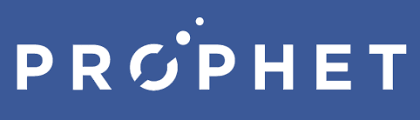

- pip install fbprophet
- Pode ser necessário fazer a seguinte instalação antes:
- conda install libpython m2w64-toolchain -c msys2
- https://stackoverflow.com/questions/51460318/microsoft-visual-c-14-0-is-required-error-pip-install-fbprophet

In [5]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [6]:
# Leitura dos dados - Vendas Varejo
sales_df = pd.read_csv('example_retail_sales.csv', index_col='Date', parse_dates=True)

In [7]:
sales_df.head()

,Sales
Date,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


# Preparação dos dados para o Prophet

O Prophet exige que os dados estam organizados como 'ds' (datas) e 'y' (valor). 

In [8]:
df = sales_df.reset_index()

In [9]:
df.head()

,Date,Sales
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [10]:
# Vamos renomear as colunas
df=df.rename(columns={'Date':'ds', 'Sales':'y'})

In [11]:
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


Desenho do plot com os dados

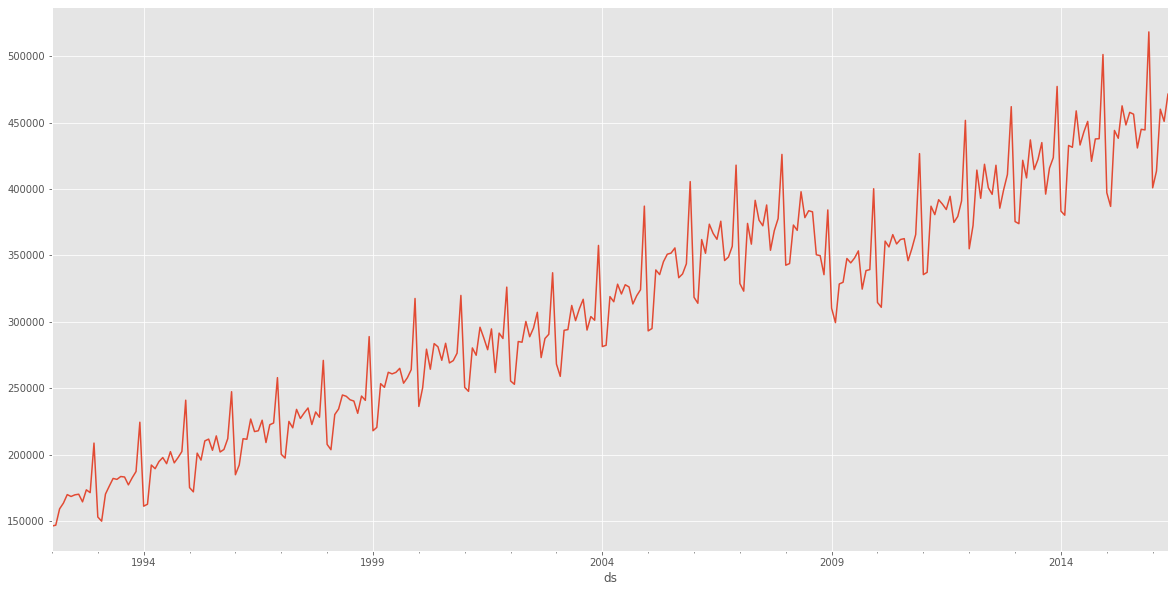

In [12]:
df.set_index('ds').y.plot()

Transformação dos dados aplicando a função log do numpy

In [13]:
df['y'] = np.log(df['y'])

In [14]:
df.tail()

,ds,y
288,2016-01-01,12.901537
289,2016-02-01,12.932543
290,2016-03-01,13.039184
291,2016-04-01,13.019078
292,2016-05-01,13.063507


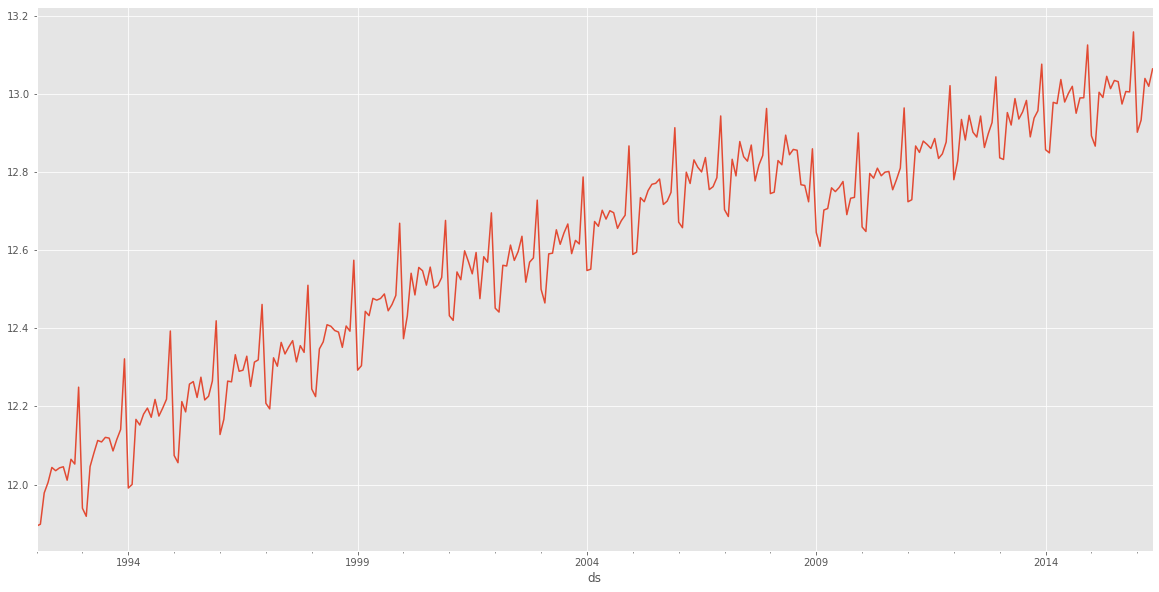

In [15]:
df.set_index('ds').y.plot()

# Execução do Prophet
- A ferramenta automaticamente seleciona uma sazonalidade adequada (ver avisos abaixo)

In [16]:
model = Prophet()
model.fit(df);

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Montagem do dataframe que irá receber os dados das predições

In [17]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
312,2017-12-31
313,2018-01-31
314,2018-02-28
315,2018-03-31
316,2018-04-30


Execução da predição do modelo instanciado.

In [18]:
forecast = model.predict(future)

Resultado da execução:

In [19]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
312,2017-12-31,13.098738,12.925450,13.032220,13.048390,13.152145,-0.120683,-0.120683,-0.120683,-0.120683,-0.120683,-0.120683,0.0,0.0,0.0,12.978056
313,2018-01-31,13.101735,12.948879,13.069028,13.046812,13.158717,-0.091193,-0.091193,-0.091193,-0.091193,-0.091193,-0.091193,0.0,0.0,0.0,13.010542
314,2018-02-28,13.104441,13.035684,13.161108,13.045577,13.167270,-0.006330,-0.006330,-0.006330,-0.006330,-0.006330,-0.006330,0.0,0.0,0.0,13.098111
315,2018-03-31,13.107438,13.024424,13.159335,13.043728,13.174847,-0.018631,-0.018631,-0.018631,-0.018631,-0.018631,-0.018631,0.0,0.0,0.0,13.088807
316,2018-04-30,13.110338,13.071468,13.214954,13.043024,13.181637,0.030753,0.030753,0.030753,0.030753,0.030753,0.030753,0.0,0.0,0.0,13.141091


Seleção dos dados específicos das predições da série temporal:

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot dos resultados

Prophet tem uma função embarcada que já faz o desenho do gráfico - plot.

In [ ]:
model.plot(forecast);

# Montando a visualização no formato original dos dados

Equalização dos índices para```ds```

In [ ]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Junção dos dados originais e do forecast

In [ ]:
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

Observação: os dados da predição ainda estão em valores relativos à transformação logarítimica que realizamos.

In [ ]:
viz_df.head()

In [ ]:
# retornando os dados de log para a escala original
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [ ]:
viz_df.head()

Visualização dos dados das vendas e do yhat restaurado ao valor original

In [ ]:
viz_df[['Sales', 'yhat_rescaled']].plot()

In [ ]:
# vamos utilizar a data como índice
sales_df.index = pd.to_datetime(sales_df.index) 
# seleciona a penúltima data
connect_date = sales_df.index[-2]

In [ ]:
# critério com os índices maiores que a penúltima
mask = (forecast.index > connect_date)
# seleção dos 
predict_df = forecast.loc[mask]

In [ ]:
# o predict_df terá somente os valores abaixo que forem True
mask

In [ ]:
predict_df

Construção do DataFrame para a visualização.

In [ ]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df

Adição da coluna com o yhat original

In [ ]:
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

## Visualizaçao Final

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.Sales)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')